## Import packages

In [74]:
import sys
print(sys.version)

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from rasterio.plot import show
from datetime import datetime

import pandas as pd
import rasterio

# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]


## Import the tabular data

In [2]:
buffalo_id = 2005
n_samples = 10297 # 2005 has 10297 samples

# buffalo_id = 2018
# n_samples = 9440 # 2018 has 9440 samples

# Specify the path to your CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

    bearing  bearing_sin  bearing_cos        ta    cos_ta         x_min  \
0  2.802478     0.33265

## Importing spatial data

## Global layers

### NDVI

In [3]:
file_path = '../mapping/cropped rasters/ndvi_2018-19_late_dry.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    ndvi_global = src.read(1)
    # Get the metadata of the raster
    ndvi_meta = src.meta
    raster_transform = src.transform


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_epsg(3112), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
| 25.00, 0.00, 0.00|
| 0.00,-25.00,-1406000.00|
| 0.00, 0.00, 1.00|
(2280, 2400)


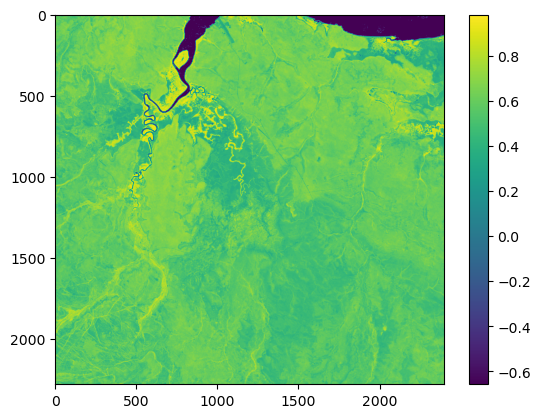

In [81]:
print(ndvi_meta)
print(raster_transform)
print(ndvi_global.shape)

# Replace NaNs in the original array with -1, which represents water
ndvi_global = np.nan_to_num(ndvi_global, nan=-1.0)

# create water mask
water_mask = ndvi_global == -1.0

# from the stack of local layers
ndvi_max = 0.8220
ndvi_min = -0.2772

ndvi_global_tens = torch.from_numpy(ndvi_global)

# Normalizing the data
ndvi_global_norm = (ndvi_global_tens - ndvi_min) / (ndvi_max - ndvi_min)

plt.imshow(ndvi_global_norm.numpy())
plt.colorbar()  
plt.show()


### Canopy cover

In [5]:
file_path = '../mapping/cropped rasters/canopy_cover.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    canopy_global = src.read(1)
    # Get the metadata of the raster
    canopy_meta = src.meta


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_epsg(3112), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
(2280, 2400)


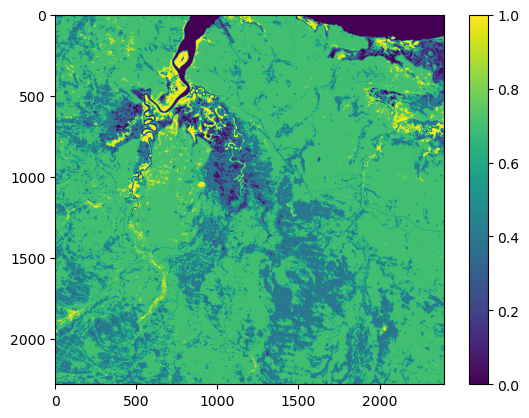

In [6]:
print(canopy_meta)
print(canopy_global.shape)

# from the stack of local layers
canopy_max = 82.5000
canopy_min = 0.0

canopy_global_tens = torch.from_numpy(canopy_global)

# Normalizing the data
canopy_global_norm = (canopy_global_tens - canopy_min) / (canopy_max - canopy_min)

plt.imshow(canopy_global_norm.numpy())
plt.colorbar()  
plt.show()


### Herbaceous vegetation

In [7]:
file_path = '../mapping/cropped rasters/veg_herby.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    herby_global = src.read(1)
    # Get the metadata of the raster
    herby_meta = src.meta


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_epsg(3112), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
(2280, 2400)


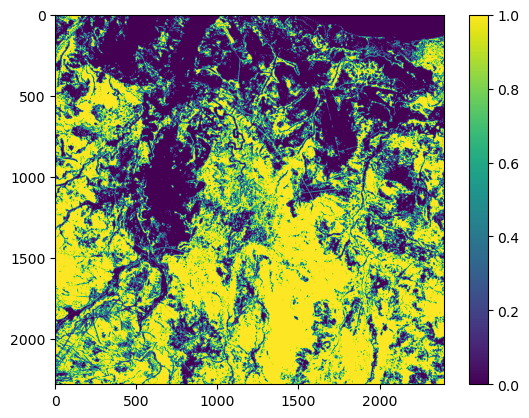

In [8]:
print(herby_meta)
print(herby_global.shape)

# from the stack of local layers
herby_max = 1.0
herby_min = 0.0

herby_global_tens = torch.from_numpy(herby_global)

# Normalizing the data
herby_global_norm = (herby_global_tens - herby_min) / (herby_max - herby_min)

plt.imshow(herby_global_norm.numpy())
plt.colorbar()  
plt.show()


### Slope

In [9]:
file_path = '../mapping/cropped rasters/slope.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    slope_global = src.read(1)
    # Get the metadata of the raster
    slope_meta = src.meta
    slope_transform = src.transform # same as the raster transform in the NDVI raster read

print(slope_global)
print(slope_transform)


[[       nan        nan        nan ...        nan        nan        nan]
 [       nan 0.3352837  0.39781624 ... 0.         0.                nan]
 [       nan 0.3983888  0.48142004 ... 0.         0.                nan]
 ...
 [       nan 2.215875   1.9798415  ... 1.5078747  1.268342          nan]
 [       nan 1.9740707  1.7354656  ... 1.697194   1.4880029         nan]
 [       nan        nan        nan ...        nan        nan        nan]]
| 25.00, 0.00, 0.00|
| 0.00,-25.00,-1406000.00|
| 0.00, 0.00, 1.00|


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_epsg(3112), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
(2280, 2400)


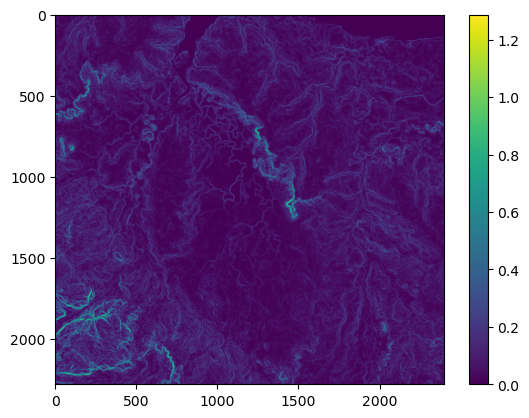

In [10]:
print(slope_meta)
print(slope_global.shape)

# Replace NaNs in the original array with -1, which represents water
slope_global = np.nan_to_num(slope_global, nan=0.0)

# from the stack of local layers
slope_max = 12.2981
slope_min = 0.0006

slope_global_tens = torch.from_numpy(slope_global)

# Normalizing the data
slope_global_norm = (slope_global_tens - slope_min) / (slope_max - slope_min)

plt.imshow(slope_global_norm.numpy())
plt.colorbar()  
plt.show()


Testing functions for selecting subsets of the raster layer, using torch objects

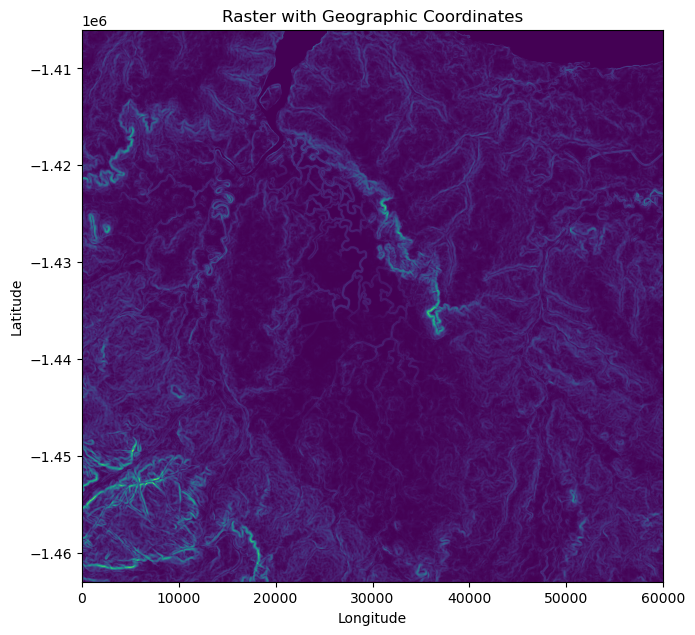

In [11]:
# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))

# Plot the raster
show(slope_global, transform=raster_transform, ax=ax, cmap='viridis')

# Set the title and labels
ax.set_title('Raster with Geographic Coordinates')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [12]:
x, y = 5.9e4, -1.447e6
print(x, y)

# Convert geographic coordinates to pixel coordinates
px, py = ~raster_transform * (x, y)
# Round pixel coordinates to integers
px, py = int(round(px)), int(round(py))

# Print the pixel coordinates	
print(px, py)

59000.0 -1447000.0
2360 1640


# Running the model on the subset layers

### Set the device for the model

In [13]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


# Define the model

In [14]:
class Conv2d_block_toFC(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_toFC, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        self.kernel_size_mp = params.kernel_size_mp
        self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Flatten())

    def forward(self, x):
        return self.conv2d(x)


class Conv2d_block_spatial(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_spatial, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        # self.kernel_size_mp = params.kernel_size_mp
        # self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=1, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        )

    def forward(self, x):
        # print("Shape before squeeze:", self.conv2d(x).shape)
        conv2d_spatial = self.conv2d(x).squeeze(dim = 1)
        # print("Shape before logsumexp:", conv2d_spatial.shape)
        conv2d_spatial = conv2d_spatial - torch.logsumexp(conv2d_spatial, dim = (1, 2), keepdim = True)
        # conv2d_spatial = conv2d_spatial/torch.sum(conv2d_spatial)
        return conv2d_spatial


class FCN_block_all_habitat(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_habitat, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.image_dim * self.image_dim)
        )

    def forward(self, x):
        return self.ffn(x)


class FCN_block_all_movement(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_movement, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.num_movement_params = params.num_movement_params
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.num_movement_params)
        )

    def forward(self, x):
        return self.ffn(x)

class FCN_block_nonspatial(nn.Module):
    def __init__(self, params):
        super(FCN_block_nonspatial, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_nonspatial = params.dense_dim_in_nonspatial
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_nonspatial, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_out)
        )

    def forward(self, x):
        return self.ffn(x)



##################################################
# Mixture of two Gamma and von Mises distributions with the von Mises mu parameters allowed to vary
##################################################

class Params_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Params_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.pixel_size = params.pixel_size
        self.center = self.image_dim // 2
        y, x = np.indices((self.image_dim, self.image_dim))
        self.distance_layer = torch.from_numpy(np.sqrt((self.pixel_size*(x - self.center))**2 + (self.pixel_size*(y - self.center))**2))
        # change the centre cell to the average distance from the centre to the edge of the pixel
        self.distance_layer[self.center, self.center] = 0.56*self.pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)
        # self.bearing_layer = torch.from_numpy(np.arctan2(y - self.center, x - self.center))
        self.bearing_layer = torch.from_numpy(np.arctan2(self.center - y, x - self.center))
        self.device = params.device


    # Gamma desnities for the mixture distribution
    def gamma_density(self, x, shape, scale):
        # Ensure all tensors are on the same device as x
        shape = shape.to(x.device)
        scale = scale.to(x.device)
        return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale

    # von Mises densities for the mixture distribution
    def vonmises_density(self, x, kappa, vm_mu):
        # Ensure all tensors are on the same device as x
        kappa = kappa.to(x.device)
        vm_mu = vm_mu.to(x.device)
        return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))


    def forward(self, x, bearing):

        # parameters of the first mixture distribution
        gamma_shape1 = torch.exp(x[:, 0]).unsqueeze(0).unsqueeze(0)
        gamma_shape1 = gamma_shape1.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape1 = gamma_shape1.permute(2, 0, 1)

        gamma_scale1 = torch.exp(x[:, 1]).unsqueeze(0).unsqueeze(0)
        gamma_scale1 = gamma_scale1.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale1 = gamma_scale1.permute(2, 0, 1)

        gamma_weight1 = torch.exp(x[:, 2]).unsqueeze(0).unsqueeze(0)
        gamma_weight1 = gamma_weight1.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight1 = gamma_weight1.permute(2, 0, 1)

        # parameters of the second mixture distribution
        gamma_shape2 = torch.exp(x[:, 3]).unsqueeze(0).unsqueeze(0)
        gamma_shape2 = gamma_shape2.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape2 = gamma_shape2.permute(2, 0, 1)

        gamma_scale2 = torch.exp(x[:, 4]).unsqueeze(0).unsqueeze(0)
        gamma_scale2 = gamma_scale2 * 500 ### to transform the scale parameter to be near 1
        gamma_scale2 = gamma_scale2.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale2 = gamma_scale2.permute(2, 0, 1)

        gamma_weight2 = torch.exp(x[:, 5]).unsqueeze(0).unsqueeze(0)
        gamma_weight2 = gamma_weight2.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight2 = gamma_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        gamma_weights = torch.stack([gamma_weight1, gamma_weight2], dim=0)
        gamma_weights = torch.nn.functional.softmax(gamma_weights, dim=0)
        gamma_weight1 = gamma_weights[0]
        gamma_weight2 = gamma_weights[1]

        # calculation of Gamma densities
        gamma_density_layer1 = self.gamma_density(self.distance_layer, gamma_shape1, gamma_scale1).to(device)
        gamma_density_layer2 = self.gamma_density(self.distance_layer, gamma_shape2, gamma_scale2).to(device)

        # combining both densities to create a mixture distribution using logsumexp
        logsumexp_gamma_corr = torch.max(gamma_density_layer1, gamma_density_layer2)
        gamma_density_layer = logsumexp_gamma_corr + torch.log(gamma_weight1 * torch.exp(gamma_density_layer1 - logsumexp_gamma_corr) + gamma_weight2 * torch.exp(gamma_density_layer2 - logsumexp_gamma_corr))
        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))

        # normalise the gamma weights so they sum to 1
        # gamma_density_layer = gamma_density_layer - torch.logsumexp(gamma_density_layer, dim = (1, 2), keepdim = True)
        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))


        ## Von Mises Distributions

        # calculate the new bearing from the turning angle
        # takes in the bearing from the previous step and adds the turning angle
        bearing_new1 = x[:, 6] + bearing[:, 0]
        # bearing_new1 = 0.0 + bearing[:, 0]

        # print('Bearing.shape ', bearing.shape)
        # print('Bearing[:, 0].shape ', bearing[:, 0].shape)
        # print('Bearing[:, 0] ', bearing[:, 0])
        # the new bearing becomes the mean of the von Mises distribution
        # the estimated parameter [x:, 7] is the turning angle of the next step
        # which is always in reference to the input bearing
        vonmises_mu1 = bearing_new1.unsqueeze(0).unsqueeze(0)
        vonmises_mu1 = vonmises_mu1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu1 = vonmises_mu1.permute(2, 0, 1)

        # parameters of the first von Mises distribution
        vonmises_kappa1 = torch.exp(x[:, 7]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa1 = vonmises_kappa1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa1 = vonmises_kappa1.permute(2, 0, 1)

        vonmises_weight1 = torch.exp(x[:, 8]).unsqueeze(0).unsqueeze(0)
        vonmises_weight1 = vonmises_weight1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight1 = vonmises_weight1.permute(2, 0, 1)

        # vm_mu and weight for the second von Mises distribution
        bearing_new2 = x[:, 9] + bearing[:, 0]
        # bearing_new2 = torch.pi + bearing[:, 0]
        # bearing_new2 = -torch.pi + bearing[:, 0]

        vonmises_mu2 = bearing_new2.unsqueeze(0).unsqueeze(0)
        vonmises_mu2 = vonmises_mu2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu2 = vonmises_mu2.permute(2, 0, 1)

        # parameters of the second von Mises distribution
        vonmises_kappa2 = torch.exp(x[:, 10]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa2 = vonmises_kappa2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa2 = vonmises_kappa2.permute(2, 0, 1)

        vonmises_weight2 = torch.exp(x[:, 11]).unsqueeze(0).unsqueeze(0)
        vonmises_weight2 = vonmises_weight2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight2 = vonmises_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        vonmises_weights = torch.stack([vonmises_weight1, vonmises_weight2], dim=0)
        vonmises_weights = torch.nn.functional.softmax(vonmises_weights, dim=0)
        vonmises_weight1 = vonmises_weights[0]
        vonmises_weight2 = vonmises_weights[1]

        # calculation of von Mises densities
        vonmises_density_layer1 = self.vonmises_density(self.bearing_layer, vonmises_kappa1, vonmises_mu1).to(device)
        vonmises_density_layer2 = self.vonmises_density(self.bearing_layer, vonmises_kappa2, vonmises_mu2).to(device)

        # combining both densities to create a mixture distribution using the logsumexp trick
        logsumexp_vm_corr = torch.max(vonmises_density_layer1, vonmises_density_layer2)
        vonmises_density_layer = logsumexp_vm_corr + torch.log(vonmises_weight1 * torch.exp(vonmises_density_layer1 - logsumexp_vm_corr) + vonmises_weight2 * torch.exp(vonmises_density_layer2 - logsumexp_vm_corr))
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # normalise so the densities sum to 1 when exponentiated
        # vonmises_density_layer = vonmises_density_layer - torch.logsumexp(vonmises_density_layer, dim = (1, 2), keepdim = True)
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # combining the two distributions
        movement_grid = gamma_density_layer + vonmises_density_layer # Gamma and von Mises densities are on the log-scale
        # print('Movement grid ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))
        movement_grid = movement_grid - torch.logsumexp(movement_grid, dim = (1, 2), keepdim = True)
        # print('Movement grid norm ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))

        return movement_grid


class Scalar_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Scalar_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device

    def forward(self, x):
        num_scalars = x.shape[1]
        scalar_map = x.view(x.shape[0], num_scalars, 1, 1).expand(x.shape[0], num_scalars, self.image_dim, self.image_dim)
        return scalar_map


class Vector_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Vector_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device

    def forward(self, x):
        x_unnorm = x.reshape(x.shape[0], self.image_dim, self.image_dim)
        x = x_unnorm - torch.logsumexp(x_unnorm, dim = (1, 2), keepdim = True)
        return x

        # x = x_unnorm/torch.sum(x_unnorm)
        # return x


class ConvJointModel(nn.Module):
    def __init__(self, params):
        super(ConvJointModel, self).__init__()
        # self.conv_habitat = Conv2d_block(params)
        # self.fcn_habitat_all = FCN_block_all_habitat(params)
        # self.fcn_habitat_nonspatial = FCN_block_nonspatial(params)
        # self.habitat_grid_output = Vector_to_Grid_Block(params)

        self.scalar_grid_output = Scalar_to_Grid_Block(params)
        self.conv_habitat = Conv2d_block_spatial(params)

        self.conv_movement = Conv2d_block_toFC(params)
        self.fcn_movement_all = FCN_block_all_movement(params)
        self.fcn_movement_nonspatial = FCN_block_nonspatial(params)
        self.movement_grid_output = Params_to_Grid_Block(params)
        self.device = params.device

    def forward(self, x):
        spatial_data_x = x[0]
        scalars_to_grid = x[1]
        # additional_data_x = x[2]
        bearing_x = x[2]

        # conv_habitat = self.conv_habitat(spatial_data_x)
        # covariates_habitat = self.fcn_habitat_nonspatial(additional_data_x)
        # all_predictors_habitat = torch.cat([conv_habitat, covariates_habitat], dim = 1)
        # # print(f"Shape after concatenation: {all_predictors_habitat.shape}")  # Debugging print
        # output_habitat = self.fcn_habitat_all(all_predictors_habitat)
        # output_habitat = self.habitat_grid_output(output_habitat)

        # SCALAR GRIDS
        scalar_grids = self.scalar_grid_output(scalars_to_grid)
        all_spatial = torch.cat([spatial_data_x, scalar_grids], dim = 1)
        # print(f"Shape after scalar grid: {all_spatial.shape}")  # Debugging print


        # HABITAT SELECTION
        output_habitat = self.conv_habitat(all_spatial)
        # print(f"Shape after CNN habitat: {output_habitat.shape}")  # Debugging print


        # MOVEMENT
        conv_movement = self.conv_movement(all_spatial)
        # print(f"Shape after CNN to FC movement: {conv_movement.shape}")  # Debugging print

        # covariates_movement = self.fcn_movement_nonspatial(additional_data_x)
        # print(f"Shape after fcn_movement_nonspatial: {covariates_movement.shape}")  # Debugging print

        # all_predictors_movement = torch.cat([conv_movement, covariates_movement], dim = 1)
        # print(f"Shape after torch.cat([conv_movement, covariates_movement], dim = 1): {all_predictors_movement.shape}")  # Debugging print

        output_movement = self.fcn_movement_all(conv_movement)
        # print(f"Shape after fcn_movement_all: {output_movement.shape}")  # Debugging print
        output_movement = self.movement_grid_output(output_movement, bearing_x)
        # print(f"Shape after CNN movement: {output_movement.shape}")  # Debugging print

        # combine the habitat and movement predictions
        output = torch.stack((output_habitat, output_movement), dim = -1)
        return output


class ModelParams():
    def __init__(self, dict_params):
        self.batch_size = dict_params["batch_size"]
        self.image_dim = dict_params["image_dim"]
        self.pixel_size = dict_params["pixel_size"]
        self.batch_size = dict_params["batch_size"]
        self.dim_in_nonspatial_to_grid = dict_params["dim_in_nonspatial_to_grid"]
        self.dense_dim_in_nonspatial = dict_params["dense_dim_in_nonspatial"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.dense_dim_in_all = dict_params["dense_dim_in_all"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.input_channels = dict_params["input_channels"]
        self.output_channels = dict_params["output_channels"]
        self.kernel_size = dict_params["kernel_size"]
        self.stride = dict_params["stride"]
        self.kernel_size_mp = dict_params["kernel_size_mp"]
        self.stride_mp = dict_params["stride_mp"]
        self.padding = dict_params["padding"]
        self.image_dim = dict_params["image_dim"]
        self.num_movement_params = dict_params["num_movement_params"]
        self.dropout = dict_params["dropout"]
        self.device = dict_params["device"]


## Instantiate the model

In [15]:
params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": 4 + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

In [16]:
# load the model structure
# model = torch.load('CNN_model_global.pth')
# model.eval()

# # load the model weights
# print(model.state_dict())
model.load_state_dict(torch.load(f'model_checkpoints/checkpoint_CNN_global_buffalo{buffalo_id}_TAmix_bearing-rev_adj_hab-covs_grid-only.pt', map_location=torch.device('cpu')))
print(model.state_dict())

model.eval()

OrderedDict({'conv_habitat.conv2d.0.weight': tensor([[[[-0.1567, -0.1209,  0.0098],
          [-0.0441,  0.0237,  0.0330],
          [-0.0531,  0.1442,  0.1950]],

         [[ 0.0066, -0.0120, -0.0896],
          [-0.0151,  0.0448, -0.1268],
          [ 0.0558,  0.0477,  0.1307]],

         [[ 0.0373, -0.0647,  0.0396],
          [ 0.0106,  0.0218, -0.0784],
          [-0.1068,  0.0938, -0.1263]],

         [[ 0.1625,  0.0524, -0.1751],
          [ 0.2576, -0.0404, -0.2925],
          [-0.0265, -0.0046, -0.2990]],

         [[-0.0916, -0.0290,  0.0990],
          [ 0.0777,  0.0646,  0.0067],
          [-0.0587,  0.0151, -0.0429]],

         [[-0.0984,  0.0123, -0.0273],
          [-0.0801, -0.0057,  0.0514],
          [ 0.0727,  0.0760, -0.1162]],

         [[ 0.2283,  0.3245,  0.3245],
          [ 0.3244,  0.1986,  0.1193],
          [ 0.2414,  0.2449,  0.2621]],

         [[ 0.0509,  0.0798,  0.0166],
          [ 0.1363,  0.0779,  0.0843],
          [ 0.0586,  0.0572,  0.1212]]],


 

C:\Users\Scott Forrest\AppData\Local\Temp\ipykernel_10596\1542263426.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'model_checkpoints

ConvJointModel(
  (scalar_grid_output): Scalar_to_Grid_Block()
  (conv_habitat): Conv2d_block_spatial(
    (conv2d): Sequential(
      (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_movement): Conv2d_block_toFC(
    (conv2d): Sequential(
      (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fcn_movement_all): FCN_block_all_movement(
    (ffn): Sequential(
      (0): Linear(in_features=2500, out_features=128, b

# Run CNN component on full landscape

In [95]:
# Assuming ndvi_global_norm, canopy_global_norm, herby_global_norm, slope_global_norm, and params are already defined
ndvi_landscape = ndvi_global_norm.to(params.device)
print(ndvi_landscape.shape)
canopy_landscape = canopy_global_norm.to(params.device)
herby_landscape = herby_global_norm.to(params.device)
slope_landscape = slope_global_norm.to(params.device)

# hour of the day (hour) 
hour_t2 = 24
# convert to sine and cosine
hour_t2_sin = np.sin(2*np.pi*hour_t2/24)
hour_t2_cos = np.cos(2*np.pi*hour_t2/24)

# day of the year (yday)
yday_t2 = 250.0
# convert to sine and cosine
yday_t2_sin = np.sin(2*np.pi*yday_t2/365)
yday_t2_cos = np.cos(2*np.pi*yday_t2/365)

# Convert lists to PyTorch tensors
hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float().unsqueeze(0)
hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float().unsqueeze(0)
yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float().unsqueeze(0)
yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float().unsqueeze(0)

def scalar_to_grid(x, dim_x, dim_y):
    scalar_map = x.view(1, 1, 1, 1).expand(1, 1, dim_x, dim_y)
    return scalar_map

# Stack tensors column-wise to create a tensor of shape 
scalar_covariates = torch.stack([hour_t2_sin_tensor, hour_t2_cos_tensor, yday_t2_sin_tensor, yday_t2_cos_tensor], dim=0)
print(scalar_covariates.shape)

scalar_grids = torch.cat([scalar_to_grid(tensor, ndvi_landscape.shape[0], ndvi_landscape.shape[1]) for tensor in scalar_covariates], dim=1)
print(scalar_grids.shape)

torch.Size([2280, 2400])
torch.Size([4, 1])
torch.Size([1, 4, 2280, 2400])


In [96]:
# Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
landscape_stack = torch.stack([ndvi_landscape, canopy_landscape, herby_landscape, slope_landscape], dim=0)
landscape_stack = landscape_stack.unsqueeze(0)
print(landscape_stack.shape)

full_stack = torch.cat([landscape_stack, scalar_grids], dim=1)
print(full_stack.shape)

torch.Size([1, 4, 2280, 2400])
torch.Size([1, 8, 2280, 2400])


In [97]:
landscape_predictions = model.conv_habitat(full_stack)
print(landscape_predictions.shape)

torch.Size([1, 2280, 2400])


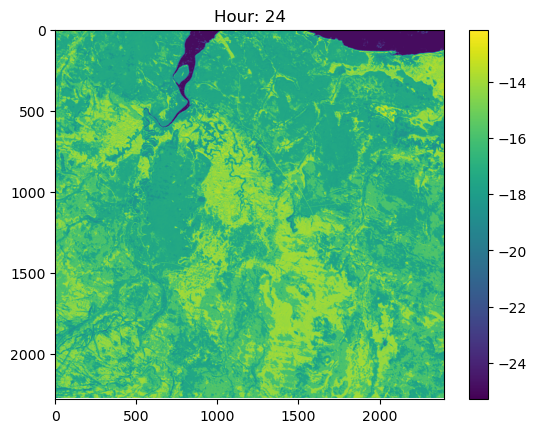

In [99]:
# Assuming the output has the shape [batch_size, channels, height, width]
# For simplicity, let's visualize the first image in the batch and its first channel
output_image = landscape_predictions[0].detach().cpu().numpy()

# Create the mask for x and y coordinates
x_mask = np.ones_like(output_image)
y_mask = np.ones_like(output_image)
water_mask = np.ones_like(output_image)

y_dim = output_image.shape[0]
x_dim = output_image.shape[1]

buffer = 3

# Create the mask for x and y coordinates
x_mask[:, :buffer] = -np.inf
x_mask[:, x_dim-buffer:] = -np.inf
y_mask[:buffer, :] = -np.inf
y_mask[y_dim-buffer:, :] = -np.inf


# mask out cells on the edges that affect the colour scale
output_image = output_image * x_mask * y_mask
# output_image[ndvi_global == -1.0] = -np.inf

# Plot the image using matplotlib
filename_landscape_preds = f"outputs/dl_prob_maps_landscape/id{buffalo_id}_hab_log_prob_norm_{today_date}_{hour_t2}.png"
plt.imshow(output_image, cmap='viridis')  # Use 'gray' for grayscale or change as needed
plt.colorbar()  # Optional: show the color scale bar
plt.title(f'Hour: {hour_t2}')
plt.savefig(filename_landscape_preds, dpi=600)
plt.show()
plt.close()  # Close the figure to free memory

## Together to loop over hours

In [100]:
# Define the range of hours you want to loop over
hours = range(25) # to start at 1

# Initialize lists to store results
scalar_grids_list = []
landscape_predictions_list = []

for hour_t2 in hours:
    # convert to sine and cosine
    hour_t2_sin = np.sin(2*np.pi*hour_t2/24)
    hour_t2_cos = np.cos(2*np.pi*hour_t2/24)

    # day of the year (yday)
    yday_t2 = 250.0
    # convert to sine and cosine
    yday_t2_sin = np.sin(2*np.pi*yday_t2/365)
    yday_t2_cos = np.cos(2*np.pi*yday_t2/365)

    # Convert lists to PyTorch tensors
    hour_t2_sin_tensor = torch.tensor(hour_t2_sin).float().unsqueeze(0)
    hour_t2_cos_tensor = torch.tensor(hour_t2_cos).float().unsqueeze(0)
    yday_t2_sin_tensor = torch.tensor(yday_t2_sin).float().unsqueeze(0)
    yday_t2_cos_tensor = torch.tensor(yday_t2_cos).float().unsqueeze(0)

    # Stack tensors column-wise to create a tensor of shape 
    scalar_covariates = torch.stack([hour_t2_sin_tensor, hour_t2_cos_tensor, yday_t2_sin_tensor, yday_t2_cos_tensor], dim=0)
    scalar_grids = torch.cat([scalar_to_grid(tensor, ndvi_landscape.shape[0], ndvi_landscape.shape[1]) for tensor in scalar_covariates], dim=1)

    full_stack = torch.cat([landscape_stack, scalar_grids], dim=1)
    # print(full_stack.shape)

    landscape_predictions = model.conv_habitat(full_stack)
    # print(landscape_predictions.shape)

    # Assuming the output has the shape [batch_size, channels, height, width]
    # For simplicity, let's visualize the first image in the batch and its first channel
    output_image = landscape_predictions[0].detach().cpu().numpy()

    # mask out cells on the edges that affect the colour scale
    output_image = output_image * x_mask * y_mask

    # Save the figure
    filename_landscape_preds = f"outputs/dl_prob_maps_landscape/id{buffalo_id}_hab_log_prob_norm_{today_date}_{hour_t2}.png"
    plt.figure()  # Create a new figure
    plt.imshow(output_image)
    plt.colorbar()
    plt.title(f'Hour: {hour_t2}')
    plt.savefig(filename_landscape_preds, dpi=600)
    plt.show()
    plt.close()  # Close the figure to free memory

TypeError: unsupported operand type(s) for +: 'range' and 'int'